In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation
from tensorflow.keras.models import Model


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


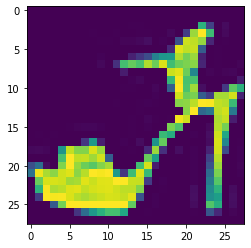

In [12]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

AssertionErrorx_train = np.expand_dims(x_train, -1)
x = x_train[9].reshape(1, 28,28,1)
plt.imshow(x[0])

In [13]:
from ri_decomp_layer import SADecompLayer

# Test SADecpmp module
print(x.shape)

'''model = keras.Sequential([
    
    keras.Input(shape=input_shape),
    SADecompLayer(w_size=4, name='sad1_1'),
    #SADecompLayer(w_size=28, name='sad2_1'),

    ])
#model.summary()
# Call model on a test input
#model = keras.Model(input, ys, name="encoder")
#model.summary()

sym = model(x)
print(sym.shape)
#asym = x - sym
plt.imshow( sym[0,:,:,0]  )'''




(1, 28, 28, 1)


'model = keras.Sequential([\n    \n    keras.Input(shape=input_shape),\n    SADecompLayer(w_size=4, name=\'sad1_1\'),\n    #SADecompLayer(w_size=28, name=\'sad2_1\'),\n\n    ])\n#model.summary()\n# Call model on a test input\n#model = keras.Model(input, ys, name="encoder")\n#model.summary()\n\nsym = model(x)\nprint(sym.shape)\n#asym = x - sym\nplt.imshow( sym[0,:,:,0]  )'

BEFORE:



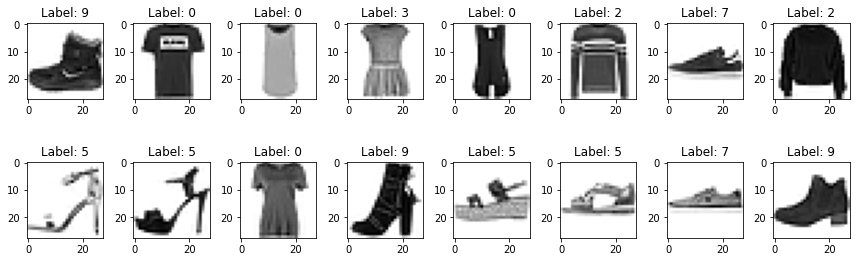

AFTER:



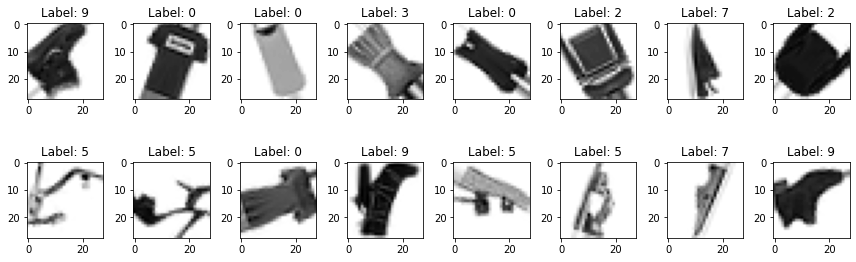

In [14]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# specify the maximum rotation_range angle
rotation_range_val = 180
# import relevant library
# create the class object
datagen = ImageDataGenerator(rotation_range=rotation_range_val)
# fit the generator
datagen.fit(x_train.reshape(x_train.shape[0], 28, 28, 1))
# define number of rows & columns
num_row = 2
num_col = 8
num = num_row*num_col
# plot before
print('BEFORE:\n')
# plot images
fig1, axes1 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
     ax = axes1[i//num_col, i%num_col]
     ax.imshow(x_train[i], cmap='gray_r')
     ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()
# plot after
print('AFTER:\n')
fig2, axes2 = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for X, Y in datagen.flow(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train.reshape(y_train.shape[0], 1),batch_size=num,shuffle=False):
     for i in range(0, num):
          ax = axes2[i//num_col, i%num_col]
          ax.imshow(X[i].reshape(28,28), cmap='gray_r')
          ax.set_title('Label: {}'.format(int(Y[i])))
     break
plt.tight_layout()
plt.show()


In [15]:
def rotateDataset(x, maxRot = 360, h=28, w=28, batch_size=100):
    datagen = ImageDataGenerator(rotation_range=maxRot)
    # fit the generator
    datagen.fit(x.reshape(x.shape[0], h, w, 1))
    out = datagen.flow(x.reshape(x.shape[0], h, w, 1), x.reshape(x.shape[0], h, w, 1), batch_size=batch_size)


    return  out

def rotateDatasetVal(x, maxRot = 360, h=28, w=28, batch_size=100):
    datagen = ImageDataGenerator(rotation_range=maxRot)
    # fit the generator
    x_orig = x.reshape(x.shape[0], h, w, 1)

    datagen.fit(x.reshape(x.shape[0], h, w, 1))
    out = datagen.flow(x.reshape(x.shape[0], h, w, 1), x_orig.reshape(x.shape[0], h, w, 1), batch_size=batch_size)


    return  out


In [16]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()


# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [17]:
def getSymAntiSym(filter):

    #patches = extract_image_patches(filters, [1, k, k, 1],  [1, k, k, 1], rates = [1,1,1,1] , padding = 'VALID')
    #print(patches)
    mat_flip_x = np.fliplr(filter)

    mat_flip_y = np.flipud(filter)

    mat_flip_xy =  np.fliplr( np.flipud(filter))

    sum = filter + mat_flip_x + mat_flip_y + mat_flip_xy
    mat_sum_rot_90 = np.rot90(sum)
    
    return  (sum + mat_sum_rot_90) / 8, filter - ((sum + mat_sum_rot_90) / 8)
    
def symMSE(trueVal, predVal):

    trueVal = tf.convert_to_tensor(trueVal, dtype="float32")
    predVal = tf.convert_to_tensor(predVal, dtype="float32")
    try:
        sTrue, aTrue = SADecompLayer(w_size = 28)(trueVal)
        sPred, aPred = SADecompLayer(w_size = 28)(predVal)


        #m = Model(inputs = input_net, outputs = sTrue)
        return keras.losses.binary_crossentropy(sTrue, sPred)
    except:
        return keras.losses.binary_crossentropy(trueVal, trueVal)




In [18]:
input_net = Input(input_shape)


#y = layers.Conv2D(32, kernel_size=(3, 3), strides = (2,2),  padding='SAME', activation=None)(input_net)
#y = layers.Conv2D(64, kernel_size=(3, 3), strides = (2,2), padding='SAME', activation=None)(s)

s, a = SADecompLayer( w_size = 3)(input_net)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(input_net)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(y)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(y)
#y = Concatenate()([y, a])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

s, a = SADecompLayer( w_size = 3)(y)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(a)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(y)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(y)
#y = Concatenate()([y, a])
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

s, a = SADecompLayer( w_size = 3)(y)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(a)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(y)
y = layers.Conv2D(32, kernel_size=(3, 3), padding='SAME', activation='relu')(y)
#y = Concatenate()([y, a])


# = Add()([y, a])

'''
y = layers.Dense(7*7*32, activation='relu')(y)
y = layers.Dense(2, activation='relu')(y)
y = layers.Dense(7*7*32, activation='relu')(y)'''


y = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(y)
y = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='relu')(y)
#y = layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(y)






model = Model(inputs = input_net, outputs = y)
model.summary()


TypeError: Exception encountered when calling layer "sa_decomp_layer_1" (type SADecompLayer).

in user code:

    File "c:\Users\AN46710\Desktop\SYS809_Feature_Matching\models\ri_decomp_layer.py", line 36, in call  *
        value = np.sqrt(((patches.shape[0]/2.0)**2.0)+((patches.shape[1]/2.0)**2.0))

    TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'


Call arguments received by layer "sa_decomp_layer_1" (type SADecompLayer):
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)

(28, 28, 1)
(100, 3, 3, 1)


AttributeError: Exception encountered when calling layer "sa_decomp_layer_19" (type SADecompLayer).

in user code:

    File "c:\Users\AN46710\Desktop\SYS809_Feature_Matching\models\ri_decomp_layer.py", line 41, in call  *
        out =  warp_polar(patches, radius=r, scaling="log")
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\skimage\_shared\utils.py", line 1070, in fixed_func  *
        return func(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\skimage\_shared\utils.py", line 1098, in fixed_func  *
        return func(*args, **kwargs)
    File "c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\skimage\transform\_warps.py", line 1132, in warp_polar  *
        if image.ndim != 2 and not multichannel:

    AttributeError: 'Tensor' object has no attribute 'ndim'


Call arguments received by layer "sa_decomp_layer_19" (type SADecompLayer):
  • inputs=tf.Tensor(shape=(1, 28, 28, 1), dtype=float32)

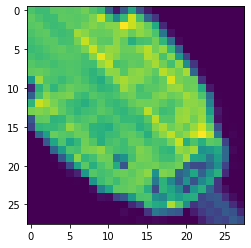

<Figure size 432x288 with 0 Axes>

In [36]:
from ri_decomp_layer import SADecompLayer

v = rotateDatasetVal(x_test, h=28, w=28)
for x, y in v:
    print(y[0].shape)
    plt.imshow(x[0])
    plt.figure()
    y = y[0].reshape(1,28,28,1)
    x = SADecompLayer( w_size = 3)(y)
    plt.imshow(x)
    break
'''plt.imshow(x[0][0])
plt.figure()
plt.imshow(y[0][0])'''

In [ ]:
batch_size = 128
epochs = 2
model.compile(loss=symMSE, optimizer="adam", metrics=["mean_squared_error"])
model.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(rotateDatasetVal(x_test, h=28, w=28)))

Epoch 1/2
469/469 [==============================] - 30s 52ms/step - loss: 0.4706 - mean_squared_error: 0.0874 - val_loss: 0.2422 - val_mean_squared_error: 0.1130
Epoch 2/2
469/469 [==============================] - 24s 52ms/step - loss: 0.4461 - mean_squared_error: 0.0705 - val_loss: 0.2422 - val_mean_squared_error: 0.1274


In [ ]:
#rotateDataset(x_test,y_test)
score = model.evaluate(rotateDataset(x_test, maxRot=360), verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


100/100 [==============================] - 3s 30ms/step - loss: 0.0000e+00 - mean_squared_error: 0.1153
Test loss: 0.0
Test accuracy: 0.11534890532493591


In [ ]:
def get_cnn_out(input, layer_num):
    get_layer_output = K.function([model.input], [l.output for l in model.layers][layer_num])
    layer_out = np.array(get_layer_output(input))
    return layer_out[0]

1/1 [==============================] - 1s 537ms/step
43 716
(28, 28, 1)
(1, 28, 28, 1)


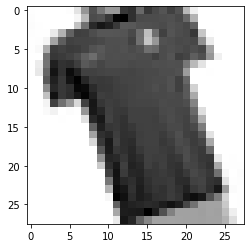

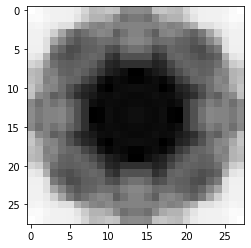

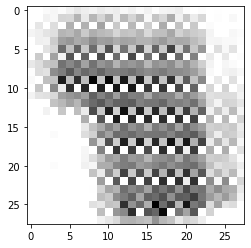

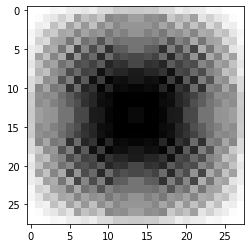

In [ ]:

for X,Y in rotateDataset(x_test, batch_size=1, maxRot=360, h=28, w=28):
    print(np.argmax(Y), np.argmax(model.predict(X)))
    plt.figure(0)  
    get_layer_output = K.function([model.input], model.layers[0].output)
    layer_out = np.array(get_layer_output([X]))
    print(layer_out[0].shape)
    plt.imshow(layer_out[0], cmap='gray_r')   

    plt.figure(1)  
    layer_out = layer_out.reshape(1,28,28,1)
    layer_out = tf.convert_to_tensor(layer_out, dtype="float")
    s, a = SADecompLayer(w_size = 28)(layer_out)
    plt.imshow(s[0], cmap='gray_r')   


    plt.figure(2)  
    get_layer_output = K.function([model.input], model.layers[-1].output)
    layer_out = np.array(get_layer_output([X]))
    print(layer_out.shape)
    plt.imshow(layer_out[0],  cmap='gray_r')   

    plt.figure(3)  
    get_layer_output = K.function([model.input], model.layers[-1].output)
    layer_out = np.array(get_layer_output([X]))
    layer_out = tf.convert_to_tensor(layer_out, dtype="float")
    s, a = SADecompLayer(w_size = 28)(layer_out)
    plt.imshow(s[0],  cmap='gray_r')   


    break

In [ ]:
np.sum(layer_out[0][0])

0.9151392